In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.25d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

Using TensorFlow backend.


In [3]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [5]:
del df['article_link'] # Deleting this column as it is of no use

In [6]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


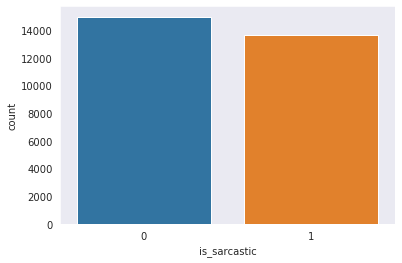

In [7]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

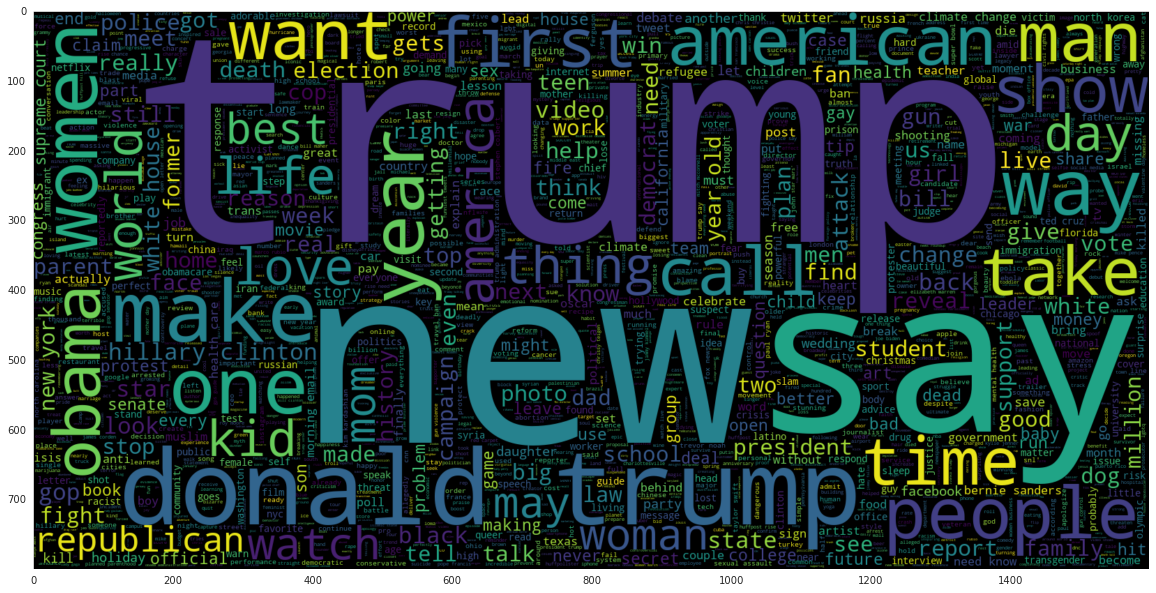

In [10]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

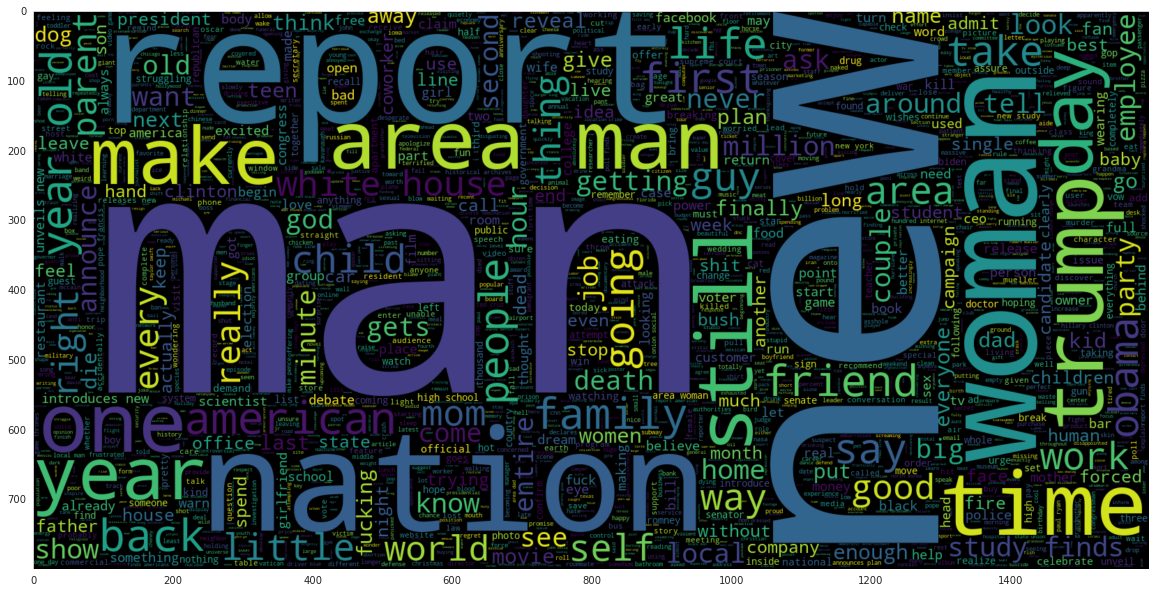

In [11]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

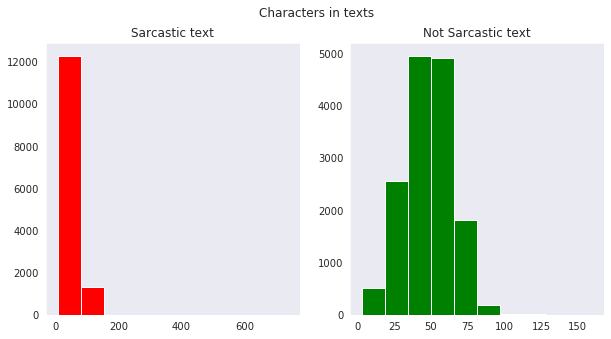

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

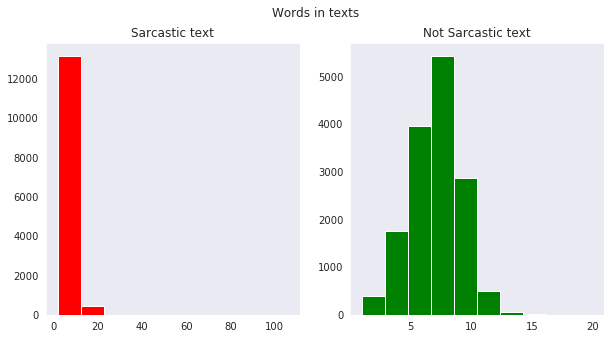

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

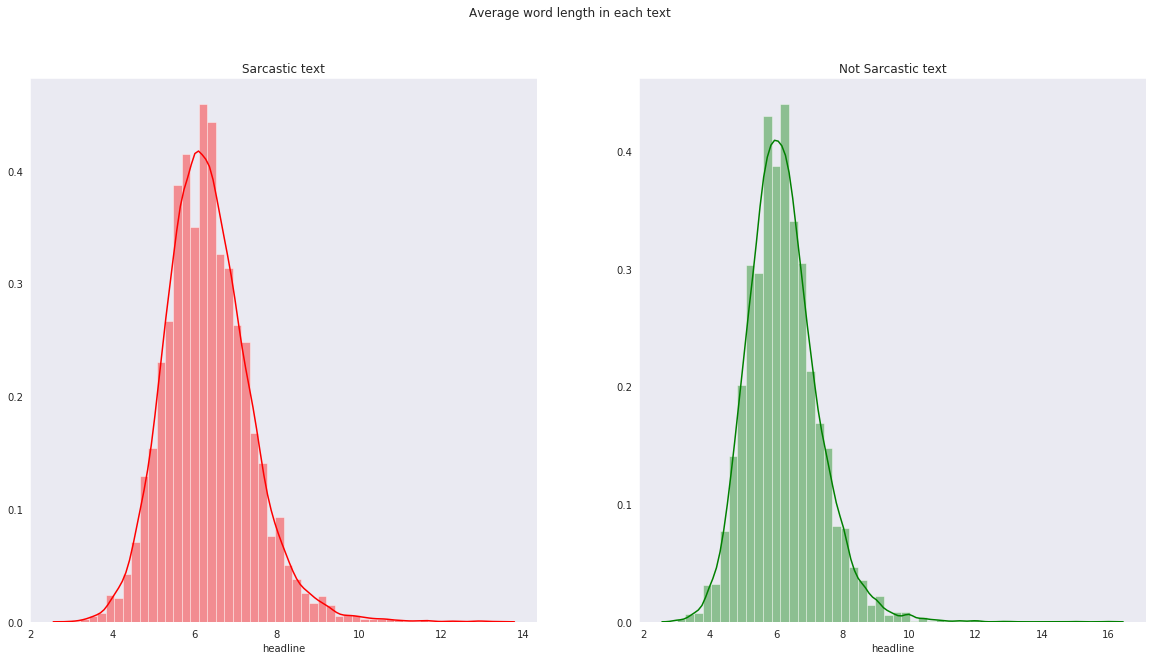

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [15]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [16]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [18]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [19]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [21]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [22]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,006,849
Trainable params: 8,006,849
Non-trainable params: 0
_________________________________________________________________


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [25]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/3
20033/20033 [==============================] - 39s 2ms/step - loss: 0.5030 - acc: 0.7498 - val_loss: 0.4262 - val_acc: 0.8055
Epoch 2/3
20033/20033 [==============================] - 34s 2ms/step - loss: 0.1624 - acc: 0.9367 - val_loss: 0.4772 - val_acc: 0.7907
Epoch 3/3
20033/20033 [==============================] - 34s 2ms/step - loss: 0.0444 - acc: 0.9853 - val_loss: 0.6111 - val_acc: 0.7965


In [26]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

20033/20033 [==============================] - 10s 522us/step
Accuracy of the model on Training Data is -  99.7154712677002
8586/8586 [==============================] - 4s 495us/step
Accuracy of the model on Testing Data is -  79.6529233455658


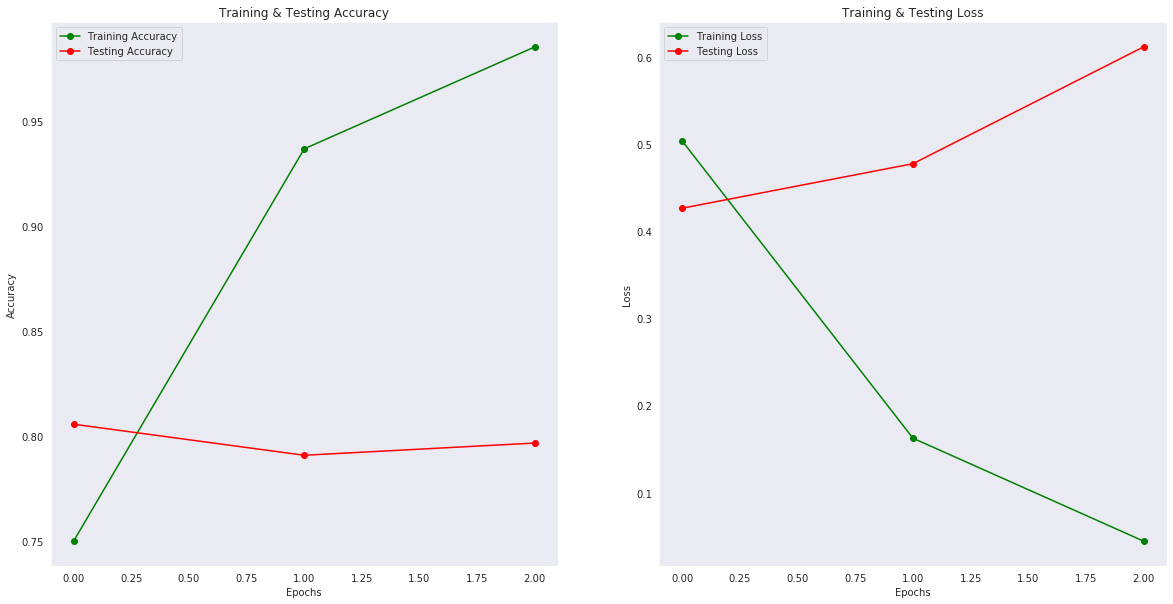

In [27]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [28]:
pred = model.predict_classes(x_test)
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [29]:
cm = confusion_matrix(y_test,pred)
cm

array([[3688,  872],
       [ 875, 3151]])

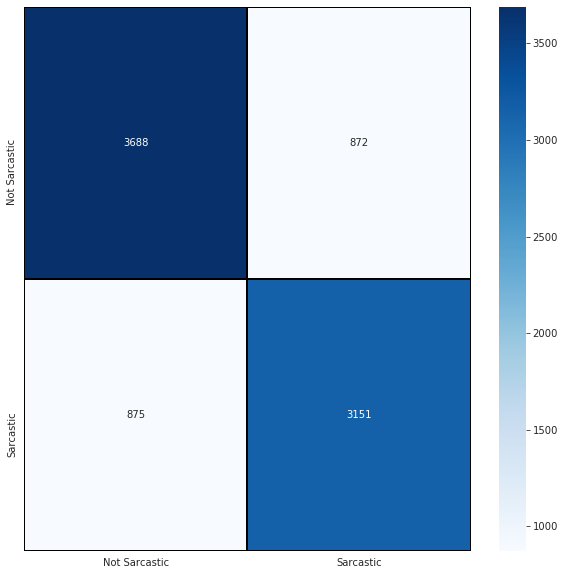

In [30]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [31]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [32]:
max_features = 35000
maxlen = 200

In [33]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [34]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [35]:
EMBEDDING_FILE = '../input/glove-twitter/glove.twitter.27B.200d.txt'

In [36]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [37]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [38]:
batch_size = 128
epochs = 2
embed_size = 200

In [39]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 200)          5165000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,502,153
Trainable params: 5,502,153
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20033 samples, validate on 8586 samples
Epoch 1/2
 6400/20033 [========>.....................] - ETA: 1:47 - loss: 0.6221 - acc: 0.6597

InvalidArgumentError:  indices[45,199] = 25825 is not in [0, 25825)
	 [[node embedding_2/embedding_lookup (defined at /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_21335]

Function call stack:
keras_scratch_graph


In [42]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

8586/8586 [==============================] - 25s 3ms/step
Accuracy of the model on Testing Data is -  78.01071405410767


In [43]:
pred = model.predict_classes(X_test)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]], dtype=int32)

In [44]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.76      0.85      0.80      4560
    Sarcastic       0.81      0.70      0.75      4026

     accuracy                           0.78      8586
    macro avg       0.78      0.78      0.78      8586
 weighted avg       0.78      0.78      0.78      8586



In [45]:
cm = confusion_matrix(y_test,pred)
cm

array([[3882,  678],
       [1210, 2816]])

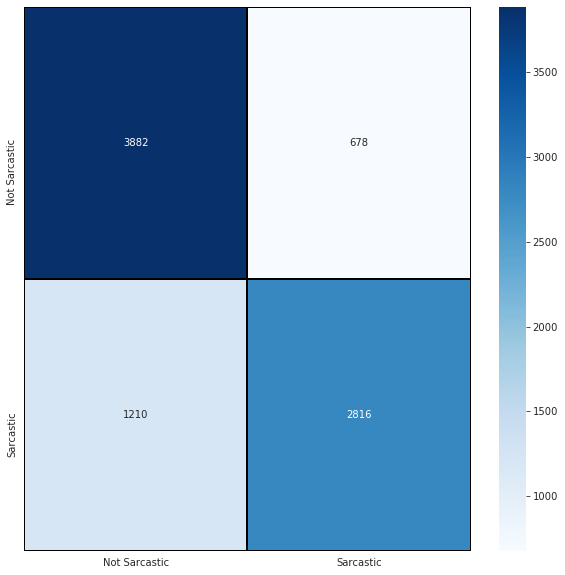

In [46]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])